# AOI definition tutorial
This tutorial describes methods and utilities for AOI definition. This module has 4 main methods of AOI definition, a class for choosing the best method for each instance, and a matcher of AOI, which provide consistence of zoning. Firstly, we will import all AOI methods and load the dataset.
> Tip: The dataset should include preprocessed data with fixations. If the data isn't preprocessed, and you want to learn how to do this, then explore the preprocessing tutorial.

In [1]:
from eyefeatures.preprocessing.aoi_extraction import ThresholdBased, ShapeBased, GradientBased
from eyefeatures.visualization.static_visualization import scanpath_visualization
import pandas as pd

In [2]:
def load_data():
    df = pd.read_csv("../data/aoi/em-y35-fasttext.csv", low_memory=False)
    df.X = df.X / df.X.max()
    df.Y = df.Y / df.Y.max()
    df = df.rename(columns={'FDUR': 'duration', 'X': 'norm_pos_x', 'Y': 'norm_pos_y'})
    X = df[['SUBJ_NAME', 'TEXT', 'norm_pos_x', 'norm_pos_y', 'duration']]
    Y = df[['SUBJ_NAME', 'TEXT', 'TEXT_TYPE', 'TEXT_TYPE_2']].drop_duplicates()
    other_features = df.drop(columns = ['SUBJ_NAME', 'TEXT', 'norm_pos_x', 'norm_pos_y', 'duration'])
    return X, Y, other_features

In [3]:
x = "norm_pos_x"
y = "norm_pos_y"
pk = ["SUBJ_NAME", "TEXT"]
aoi = "AOI"
data, target, other = load_data()
data["to_filter"] = data.apply(lambda row: '_'.join([str(row[column]) for column in pk]), axis=1)
data.head()

,SUBJ_NAME,TEXT,norm_pos_x,norm_pos_y,duration,to_filter
0,s01,chasse_oiseaux-a1,0.376268,0.384969,96,s01_chasse_oiseaux-a1
1,s01,chasse_oiseaux-a1,0.437754,0.383532,129,s01_chasse_oiseaux-a1
2,s01,chasse_oiseaux-a1,0.546146,0.382957,280,s01_chasse_oiseaux-a1
3,s01,chasse_oiseaux-a1,0.706643,0.399626,278,s01_chasse_oiseaux-a1
4,s01,chasse_oiseaux-a1,0.724645,0.397615,266,s01_chasse_oiseaux-a1


Delete the records that contain less than 2 fixation.

In [4]:
groups_count = data.groupby("to_filter").size()
mask = groups_count.loc[groups_count > 2].index
data = data.loc[data["to_filter"].isin(mask)]

Columns of data:
* ```SUBJ_NAME``` — id of the participant
* ```TEXT``` — label of the text
* ```norm_pos_x``` — normalized x-axis coordinate of the fixation [0, 1]
* ```norm_pos_y``` — normalized y-axis coordinate of the fixation [0, 1]
* ```duration``` — duration of the fixation in ms

## Shape-based method
It is a very simple method. It gets data with fixations, a list of tuples with shapes (rectangle, circle, ellipse), where each shape is a particular AOI, and a primary key. The last one is distinctive for each record. This method just checks if each fixation is in shape.

In [5]:
shapes = [['r', (0., 0.7), (1., 1.)], ('r', (0., 0.5), (1., 0.7)), ('r', (0., 0.), (1., 0.5)),]
shape_based = ShapeBased(x, y, shapes=[shapes,], pk=pk, aoi_name=aoi) 
result_sb = shape_based.transform(data)

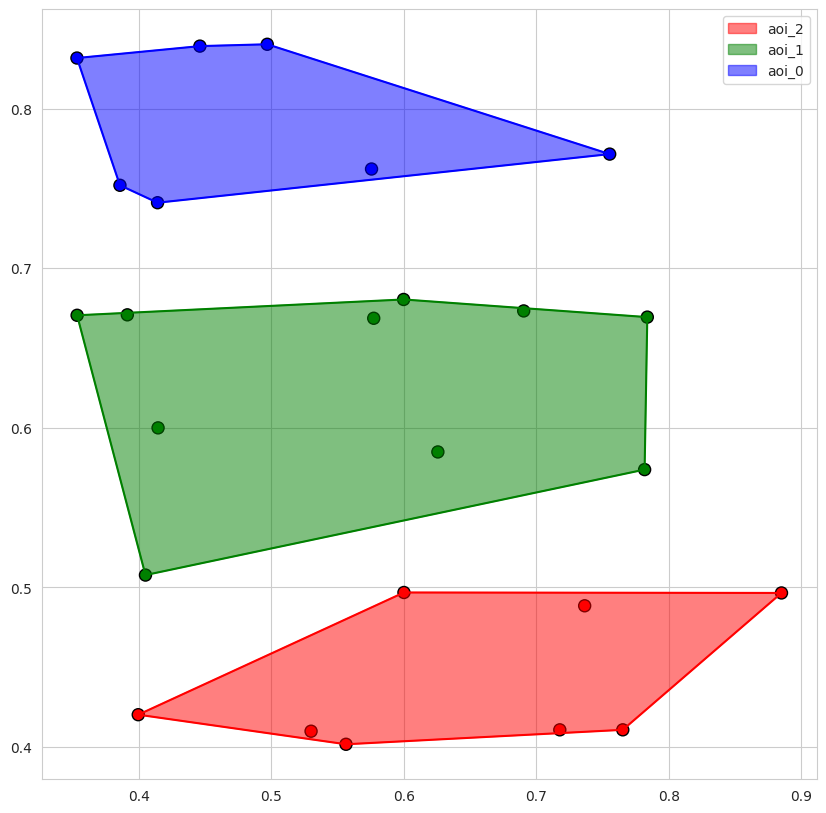

In [6]:
record = result_sb[(result_sb['SUBJ_NAME'] == "s04") & (result_sb['TEXT'] == "chasse_oiseaux-a1")]
aoi_color = {"aoi_0" : "blue", "aoi_1" : "green", "aoi_2" : "red"}
scanpath_visualization(record, x=x, y=y, aoi="AOI", show_hull=True, with_axes=True, only_points=True, show_legend=True, aoi_c=aoi_color)

## Threshold-based
This method defines AOI by using kernel density estimation and pre-thresholding it. Each maximum in the windows is the center of the AOI. This method also needs the parameter ```window_size``` (the parameter of the sliding window where the method finds the density maximum).
Steps of the algorithm:
1) Split the graph into a grid and compute density for each sector via gaussian kernel density estimation
2) Prethreshold it
3) Find the local maxima. Every maximum is a center of area of interest
4) Start to define AOI for each fixation
5) If ```algorithm_type``` is default, then it starts KMeans. Otherwise, if ```algorithm_type='basic'```, then it starts to search for the for the nearest fixation with AOI and assigns this label to the target fixation
6) Repeat for all instances

In [7]:
threshold_based = ThresholdBased(x=x, y=y, threshold=0.5, pk=pk, window_size=10, aoi_name=aoi, threshold_dist=0.1, algorithm_type="kmeans")
result_tb = threshold_based.transform(data)

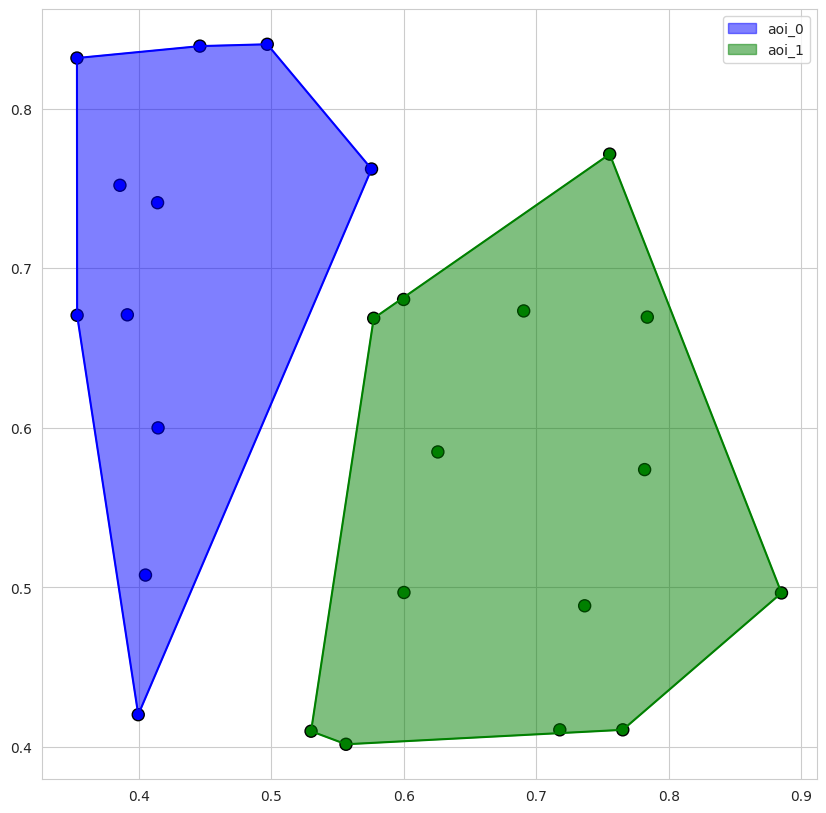

In [8]:
record = result_tb[(result_tb['SUBJ_NAME'] == "s04") & (result_tb['TEXT'] == "chasse_oiseaux-a1")]
scanpath_visualization(record, x=x, y=y, aoi=aoi, show_hull=True, with_axes=True, only_points=True, show_legend=True, aoi_c=aoi_color)

You can also try other methods. Let's take a look for some of them: <br>
### Gradient-based
This algorithm is based on gradient computing. Steps of the algorithm:
1) Split the graph into a grid and compute density for each sector via gaussian kernel density estimation.
2) Prethreshold it.
3) Find the local maxima. Every maximum is a center of area of interest.
4) Compute the gradient and magnitude.
5) Add all 8 points around of each maximum to the queue.
6) Get a point from the queue. Search among 8 points around the point with the greatest magnitude, which has AOI. Assign this label to the target point.
7) Add all 8 points with around the target point to the queue.
8) Repeat 5-8 until all points will get the AOI label.

### Overlap clustering
For overlap clustering, you should provide diameters and centers of the fixations
1) Build the clusters. Each fixation is the particular cluster. 
2) Find fixations, which are located inside other fixations, we consider this like one cluster.
3) Start to merge the clusters.
4) Find the cluster with the highest number of fixations in it (let it be the cluster <b>A</b>).
5) Find all clusters that intersect with <b>A</b> and merge them to <b>A</b>.
6) Repeat 4-5 until there are no clusters left.
<br>
<br>
This article has a more detailed description of the algorithms above [[1]](#links)

In [9]:
gradient_based = GradientBased(x=x, y=y, threshold=0.1, pk=pk, window_size=5, aoi_name=aoi)
result_gb = gradient_based.transform(data)

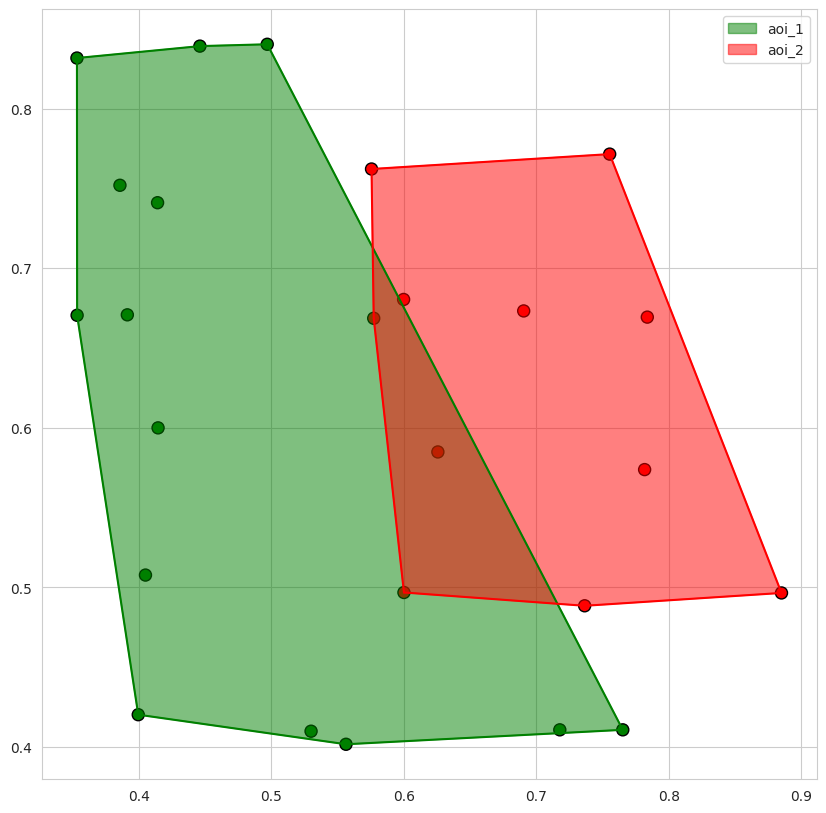

In [10]:
record = result_gb[(result_gb['SUBJ_NAME'] == "s04") & (result_gb['TEXT'] == "chasse_oiseaux-a1")]
scanpath_visualization(record, x=x, y=y, aoi=aoi, show_hull=True, with_axes=True, only_points=True, show_legend=True, aoi_c=aoi_color)

## AOI extractor
The AOI extractor gets a list of the AOI methods and selects for AOI splitting with minimal entropy. It also supports Sklearn clustering methods. The extractor has an ```instance_column``` parameter. This is to separate particular instances, not records.


In [11]:
from sklearn.cluster import KMeans
from eyefeatures.preprocessing.aoi_extraction import AOIExtractor

methods = [ThresholdBased(), KMeans(n_clusters=3)]
extractor = AOIExtractor(x=x, y=y, methods=methods, pk=pk, window_size=6, threshold=0.1,
                         instance_columns=['TEXT'], aoi_name=aoi, show_best=True)
extractor.fit(data)
result_extr = extractor.transform(data)

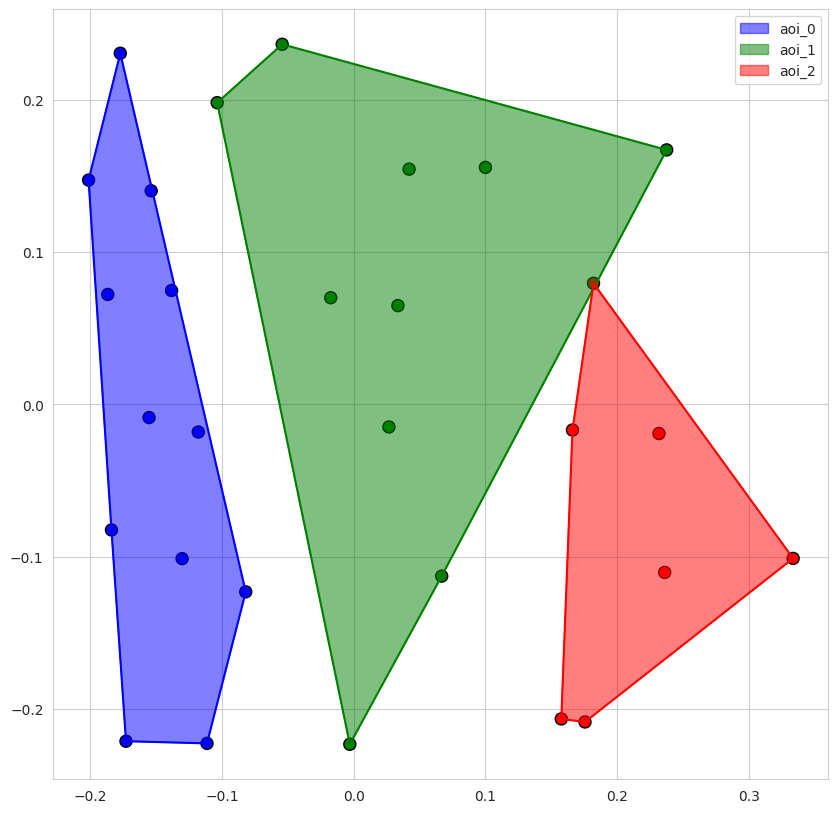

In [12]:
record = result_extr[(result_extr['SUBJ_NAME'] == "s01") & (result_extr['TEXT'] == "chasse_oiseaux-a1")]
scanpath_visualization(record, x=x, y=y, aoi=aoi, show_hull=True, with_axes=True, only_points=True, show_legend=True, aoi_c=aoi_color)

We want to know which method was chosen more often. Let's check it.

In [13]:
df = pd.concat([result_extr.loc[result_extr['best_method'] == m.__class__.__name__].groupby("to_filter").size() for m in methods], axis=1)
df.rename(columns=dict(zip(df.columns, [el.__class__.__name__ for el in methods])), inplace=True)
check_count = df.count()
check_count

ThresholdBased    1423
KMeans             960
dtype: int64

<Axes: xlabel='None'>

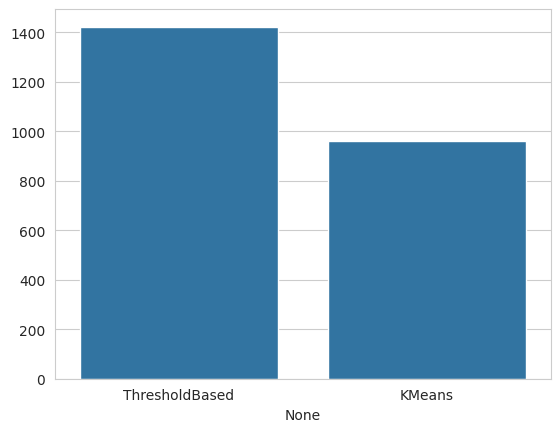

In [14]:
import seaborn as sns
sns.barplot(x=check_count.index, y=check_count.values)

## AOI Matcher
Sometimes AOI methods shuffle AOI labels. The correct order of the AOI names and features is necessary for ML/DL. That is why the AOI matcher exists. Let's match the AOI.
> Remark: The best AOI definition is considered to be the one with the lowest Shannon entropy.

In [15]:
from eyefeatures.preprocessing.aoi_extraction import AOIMatcher
matcher = AOIMatcher(x=x, y=y, pk=pk,
                     instance_columns=["TEXT"], aoi=aoi, n_aoi=3)
result_match = matcher.transform(result_extr)
result_match.head()

,SUBJ_NAME,TEXT,norm_pos_x,norm_pos_y,duration,to_filter,AOI,best_method
0,s01,aide_refugies-a1,-0.259043,-0.050774,119,s01_aide_refugies-a1,aoi_0,KMeans
1,s01,aide_refugies-a1,-0.172329,-0.043732,172,s01_aide_refugies-a1,aoi_0,KMeans
2,s01,aide_refugies-a1,-0.033891,-0.041002,103,s01_aide_refugies-a1,aoi_2,KMeans
3,s01,aide_refugies-a1,0.150820,-0.028931,236,s01_aide_refugies-a1,aoi_1,KMeans
4,s01,aide_refugies-a1,0.117732,-0.031087,173,s01_aide_refugies-a1,aoi_1,KMeans


The ```n_aoi``` parameter needs to limit the count of AOI for each record. It helps to avoid columns with ```NaN``` values.

## Pipeline
One of the most important features is the ability to use this in the Sklearn pipeline. Let's try it:

In [16]:
from sklearn.pipeline import Pipeline

extractor = AOIExtractor(methods=methods, x=x, y=y, pk=pk, instance_columns=['TEXT'], aoi_name=aoi, show_best=True)
matcher = AOIMatcher(x=x, y=y, pk=pk, instance_columns=["TEXT"], aoi=aoi, n_aoi=3)

pipeline = Pipeline([("AOIExtractor", extractor), ("AOIMatcher", matcher)])
pipeline.fit(data)
prep_data = pipeline.transform(data)

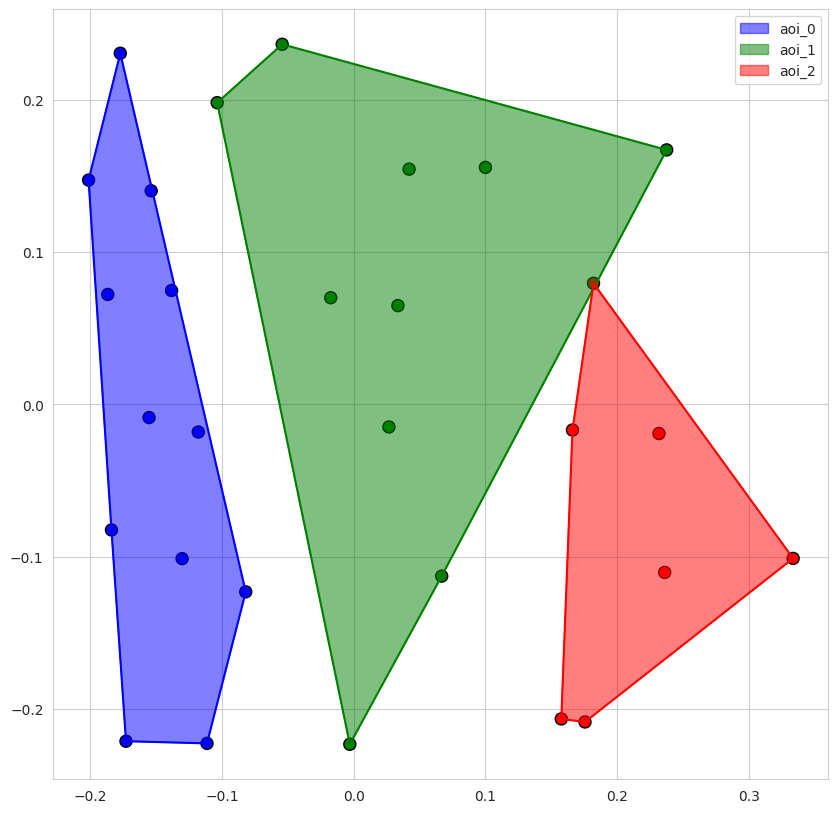

In [17]:
record = prep_data[(prep_data['SUBJ_NAME'] == "s01") & (prep_data['TEXT'] == "chasse_oiseaux-a1")]
scanpath_visualization(record, x=x, y=y, aoi=aoi, show_hull=True, with_axes=True, only_points=True, show_legend=True, aoi_c=aoi_color)

## Links
* [[1]](#links) Wolfgang Fuhl. “Image-based extraction of eye features for
robust eye tracking”. 2019. [Online] Available: https://www.hci.uni-tuebingen.de/assets/pdf/publications/WF042019.pdf